In [1]:
import seaborn
import re
import pandas as pd
import csv
import numpy as np

In [2]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [3]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
stopwords = set(stopwords.words('english'))

In [6]:
# load data from csv
scp_df = pd.read_csv('scp6999.csv', header=0, delimiter=',', quoting=csv.QUOTE_ALL, encoding='utf-8', index_col=False, usecols=['code', 'title', 'text', 'image captions', 'rating', 'state', 'tags',  'link'])

scp_df.head # quick check - note excel limits will mean opening in excel will cause issues (cells running into others etc)

<bound method NDFrame.head of           code                                              title  \
0      SCP-001             "Awaiting De-classification [Blocked]"   
1      SCP-002                                "The "Living" Room"   
2      SCP-003                           "Biological Motherboard"   
3      SCP-004                   "The 12 Rusty Keys and the Door"   
4      SCP-005                                     "Skeleton Key"   
...        ...                                                ...   
6994  SCP-6995                                  "Cannabincognito"   
6995  SCP-6996                          "Does the Red Moon Howl?"   
6996  SCP-6997                                  "De Rerum Natura"   
6997  SCP-6998  "SCP Author Cerastes's Untitled SCP-6000 Conte...   
6998  SCP-6999                          "Nearer, My God, To Thee"   

                                                   text  \
0     "GENERAL NOTICE 001-Alpha: In order to prevent...   
1     "Item #: SCP-002 

In [7]:
# setting up some functions for later use - each takes single string of words space separated, including if prefiltered by pos

In [8]:
def quick_clean(text):
  text = text.lower()
  clean_text = re.sub('[^a-zA-Z ]', '', text)
  return clean_text

In [9]:
def remove_stopwords(text):
  return " ".join([i for i in text.split() if i not in stopwords])

In [10]:
def pos_tag(text):
  return nltk.pos_tag(text.split())

In [11]:
def create_wordcloud(text):
  wordcloud = WordCloud(max_font_size=80, max_words=50, background_color="white").generate(text)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

In [12]:
def get_most_common(text):
  text = text.split()
  word_counts = {}
  for i in text:
    word_counts[i] = text.count(i)
  return sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:20]

In [13]:
def plot_most_common(text, label='Word', clr="rocket"):
  bar = seaborn.barplot([i[1] for i in text], [i[0] for i in text], orient= 'h', palette=clr)
  seaborn.despine(left=True, bottom=True)
  bar.set_xlabel('Frequency')
  bar.set_ylabel(label)

## Title Analysis

Examining the text titles of SCP articles from the main series 1 to 7

In [14]:
# extracting and preprocessing title text:
titles_raw = scp_df['title'].apply(lambda x: quick_clean(x))

### "Access Denied"

A significant minority of titles (and their articles) are not available.




In [16]:
access_denied_count = len([i for i in list(scp_df['title']) if "access denied" in i.lower()])
print("Number of titles unavailable: {}".format(access_denied_count))
print("Percentage of titles unavailable: {}%".format(round(access_denied_count / len(scp_df) * 100, 1)))

Number of titles unavailable: 410
Percentage of titles unavailable: 5.9%


In [17]:
# plotting the general distribution of unavailable titles
def get_unavailable_by_slice(data, slice_size):
  x_y_dict = {}
  for i in range(0, len(data), slice_size):
    x_y_dict["{}-{}".format(i, i + slice_size)] = len([i for i in list(data)[i: i + slice_size] if "access denied" in i.lower()])
  print("Unavailable by range: {}".format(x_y_dict))
  return [list([int(i.split("-")[1]) for i in x_y_dict.keys()]), list(x_y_dict.values())]


Unavailable by range: {'0-250': 0, '250-500': 0, '500-750': 0, '750-1000': 0, '1000-1250': 0, '1250-1500': 0, '1500-1750': 0, '1750-2000': 1, '2000-2250': 0, '2250-2500': 0, '2500-2750': 0, '2750-3000': 0, '3000-3250': 0, '3250-3500': 0, '3500-3750': 0, '3750-4000': 1, '4000-4250': 0, '4250-4500': 1, '4500-4750': 0, '4750-5000': 0, '5000-5250': 0, '5250-5500': 2, '5500-5750': 4, '5750-6000': 1, '6000-6250': 42, '6250-6500': 114, '6500-6750': 118, '6750-7000': 126}


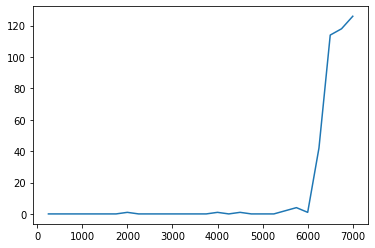

In [18]:
x_y = get_unavailable_by_slice(scp_df['title'], 250)
plt.plot(x_y[0], x_y[1])

We can see that the vast majority of unavailable articles and titles are found in the final or 7th series, from index 6000 onwards.

These unavailable titles will be removed from further analysis to avoid skewing results (their titles are identical).

In [19]:
# removing access denied from titles cleaned info
titles = [i for i in titles_raw if "access denied" not in i.lower()]

titles_nostopwords = [remove_stopwords(i) for i in titles]
titles_single_str = " ".join(titles)
titles_nostopwords_single_str = " ".join(titles_nostopwords)
pos_tagged = pos_tag(titles_single_str)

## Most Common ...

A look at the most common words of various types within the filtered titles

In [20]:
# getting some bits of data for further use
nouns_as_str = " ".join([i[0] for i in pos_tagged if i[1]=='NN'])
adjectives_as_str = " ".join([i[0] for i in pos_tagged if i[1]=='JJ'])
verbs_as_str = " ".join([i[0] for i in pos_tagged if i[1]=='VB'])

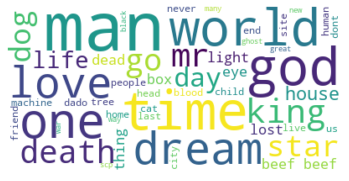

In [20]:
create_wordcloud(titles_nostopwords_single_str)

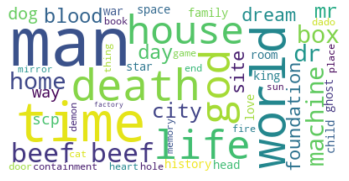

In [21]:
create_wordcloud(nouns_as_str)

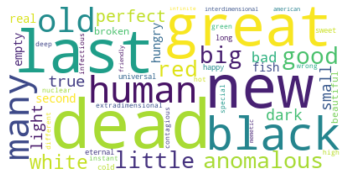

In [22]:
create_wordcloud(adjectives_as_str)

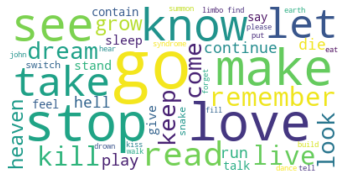

In [23]:
create_wordcloud(verbs_as_str)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


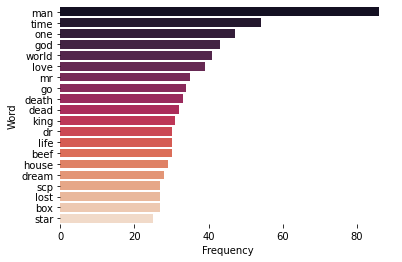

In [24]:
plot_most_common(get_most_common(titles_nostopwords_single_str))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


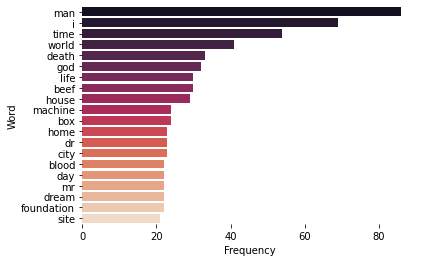

In [25]:
plot_most_common(get_most_common(nouns_as_str))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


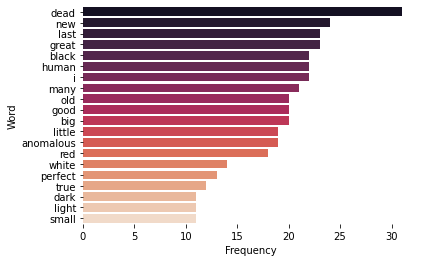

In [26]:
plot_most_common(get_most_common(adjectives_as_str))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


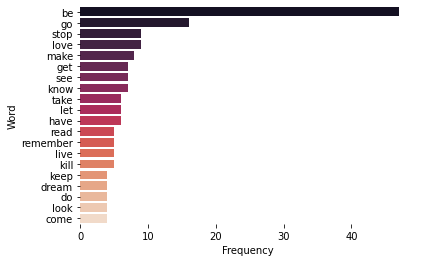

In [27]:
plot_most_common(get_most_common(verbs_as_str))

## Ratings

Examining the ratings independent of other fields

### NaN

Blocked or unavailable articles do not have an accessible rating, and a quick look shows us there are other articles with no rating

In [21]:
# no rating - key numbers
no_rating_num = len([i for i in list(scp_df['rating']) if np.isnan(i)])
print("Number of entries with no rating: {}".format(no_rating_num))
print("Percentage of entries with no rating: {}%".format(round(no_rating_num / len(scp_df)*100, 1)))

Number of entries with no rating: 398
Percentage of entries with no rating: 5.7%


In [22]:
# investigating entries with no rating that are not blocked
no_rating = scp_df[scp_df['rating'].isna()]
no_rating_not_blocked = no_rating[~no_rating['title'].str.contains("access denied", case=False)]

In [23]:
list(no_rating_not_blocked['link'])

['https://scp-wiki.wikidot.com/scp-001',
 'https://scp-wiki.wikidot.com/scp-2721',
 'https://scp-wiki.wikidot.com/scp-5468',
 'https://scp-wiki.wikidot.com/scp-5489',
 'https://scp-wiki.wikidot.com/scp-5674',
 'https://scp-wiki.wikidot.com/scp-6286',
 'https://scp-wiki.wikidot.com/scp-6351',
 'https://scp-wiki.wikidot.com/scp-6682']

Most of these are deleted, some just don't have ratings or are blocked in some way

For now, all rows with missing ratings will be filtered out.


In [24]:
# filtering out nan ratings with dropna - size of resulting dataframe also suggests there are no other columns with null values
no_nan_ratings_df = scp_df[scp_df['rating'].notna()]
# no_nan_ratings_df

In [25]:
ratings_list = list(no_nan_ratings_df['rating'])

In [26]:
# average rating - mode median mean
most_frequent_rating = max(ratings_list, key=ratings_list.count)
print("Most common rating: {}. Number of articles with this rating: {}.".format(int(most_frequent_rating), len(scp_df.loc[scp_df['rating']==most_frequent_rating])))

median_rating = sorted(ratings_list)[len(ratings_list)//2]
print("Median rating: {}".format(int(median_rating)))

average_rating = sum(ratings_list)/len(ratings_list)
print("Average rating: {}".format(int(average_rating)))

Most common rating: 55. Number of articles with this rating: 49.
Median rating: 107
Average rating: 171


In [27]:
highest_rated_article = scp_df.loc[scp_df['rating']==max(ratings_list)]
print("Highest rated article: {} {}. Rating: {}".format(highest_rated_article.code.item(), highest_rated_article.title.item(), int(max(ratings_list))))

lowest_rated_article = scp_df.loc[scp_df['rating']==min(ratings_list)]
print("Lowest rated article: {} {}. Rating: {}".format(lowest_rated_article.code.item(), lowest_rated_article.title.item(), int(min(ratings_list))))

# this lowest, negative rating looks suspicious at first, but downvotes are allowed and checking the link shows that it is accurate

Highest rated article: SCP-173 "The Original". Rating: 7651
Lowest rated article: SCP-6980 "What kind of kid drinks a lava lamp?". Rating: -35


{'boxes': [<matplotlib.lines.Line2D at 0x7f5b88da08d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f5b88da5850>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5b88dad890>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f5b88dad350>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f5b88da0d90>,
  <matplotlib.lines.Line2D at 0x7f5b88da5310>]}

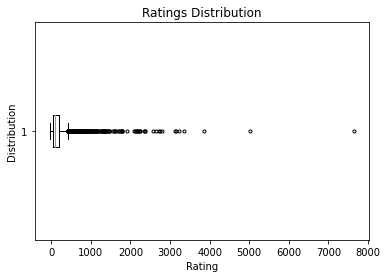

In [28]:
# rating boxplot
fig1, ax1 = plt.subplots()
ax1.set_title('Ratings Distribution')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Distribution')
ax1.boxplot(ratings_list, vert= False, sym='.')

## Tags


In [29]:
# getting all tags
all_tags = [str(i).split() for i in list(scp_df['tags'])]
from itertools import chain
all_tags = list(chain.from_iterable(all_tags))
# print(all_tags)
unique_tags = list(set(all_tags))
print(len(unique_tags)) 
print(len([i for i in unique_tags if i[0]!="_"]))
print([i for i in unique_tags if i[0]=="_"])

525
505
['_dark-and-stormy', '_famouslastwords', '_marine', '_corruption', '_townhouse', '_all-a-dream', '_graveyard-shift', '_cc', '_image', '_listpages', '_explosions', '_the-bureaucrat', '_shaggy-dog', '_pulp-fiction', '_murder-mystery', '_licensebox', '_delicious', '_meets-the-eye', '_tropical', '_llicensebox']


We see that there are 525 unique tags across this dataset, with 20 of these being hidden tags that do not display on the page, and the other 505 of these being tags the user sees. 

In [34]:
# most common tags
common_tags = sorted(unique_tags, reverse=True, key=lambda x: len([i for i in list(scp_df['tags']) if x in str(i).split()]))
most_common_tags = " ".join(common_tags[:20])
print('Most common tags: {}'.format(most_common_tags))

common_tags_visible = [i for i in common_tags if i[0]!="_"]
most_common_visible_tags = " ".join(common_tags_visible[:20])
print('Most common visible tags: {}'.format(most_common_visible_tags))

#plot
# need tags with counts
tag_counts = [(i, all_tags.count(i)) for i in unique_tags]
print(tag_counts)

# most common w counts
tags_highest_counts = sorted(tag_counts, reverse=True, key= lambda x: x[1])[:20]
tags_highest_counts_visible = sorted([i for i in tag_counts if i[0][0]!="_"], reverse=True, key= lambda x: x[1])[:20]


Most common tags: scp _cc euclid safe _licensebox sentient humanoid sapient alive keter mind-affecting animal visual cognitohazard extradimensional ectoentropic location transfiguration building uncontained
Most common visible tags: scp euclid safe sentient humanoid sapient alive keter mind-affecting animal visual cognitohazard extradimensional ectoentropic location transfiguration building uncontained biological autonomous
[('redirect', 40), ('cadaver', 350), ('marshall-carter-and-dark', 123), ('predatory', 198), ('tool', 95), ('extremity', 48), ('entropic', 38), ('golden-horde', 2), ('canine', 87), ('director-bold', 6), ('inscription', 37), ('decommissioning-dept', 10), ('mtf2016', 12), ('6000', 85), ('doctor-lillihammer', 10), ('rats-nest', 2), ('artifact', 354), ('subterranean', 170), ('self-repairing', 168), ('ontokinetic', 315), ('species', 260), ('director-moose', 20), ('rewrite', 196), ('_dark-and-stormy', 6), ('plant', 241), ('2000', 30), ('nameless', 29), ('statue', 75), ('al

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Tag')

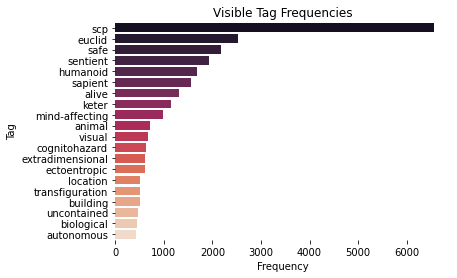

In [36]:
bar = seaborn.barplot([i[1] for i in tags_highest_counts_visible], [i[0] for i in tags_highest_counts_visible], orient= 'h', palette="rocket")
seaborn.despine(left=True, bottom=True)
bar.set_title('Visible Tag Frequencies')
bar.set_xlabel('Frequency')
bar.set_ylabel('Tag')

In [37]:
# least common w counts
tags_lowest_counts = sorted(tag_counts, key= lambda x: x[1])[:20]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Tag')

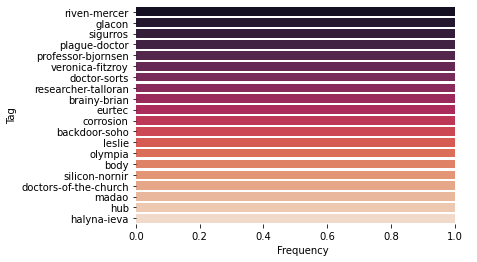

In [38]:
bar = seaborn.barplot([i[1] for i in tags_lowest_counts], [i[0] for i in tags_lowest_counts], orient= 'h', palette="rocket")
seaborn.despine(left=True, bottom=True)
bar.set_xlabel('Frequency')
bar.set_ylabel('Tag')

# this shows us there's loads with a single tag, so will also list all tags that only appear once

In [39]:
one_off_tags = [i[0] for i in tag_counts if i[1]==1]
print(len(one_off_tags), one_off_tags)
# 31 tags of this type

31 ['riven-mercer', 'glacon', 'sigurros', 'plague-doctor', 'professor-bjornsen', 'veronica-fitzroy', 'doctor-sorts', 'researcher-talloran', 'brainy-brian', 'eurtec', 'corrosion', 'backdoor-soho', 'leslie', 'olympia', 'body', 'silicon-nornir', 'doctors-of-the-church', 'madao', 'hub', 'halyna-ieva', 'judy-papill', 'rei2015', 'heather-mason', 'aaron-siegel', 'cool-war-2', 'agent-green', 'saint-hedwig', 'doctor-fynegan', 'the-specter', 'alexei-belitrov', '_llicensebox']


### Ratings by Tag

In [41]:
# getting all ratings for articles with each tag
tag_ratings = {}

for i in unique_tags:
  article_num = 0
  ratings = 0
  rating_tags = [[i, y] for x, y in zip(scp_df['tags'], scp_df['rating']) if i in str(x)]
  tag_ratings[i] = [j[1] for j in rating_tags]

In [42]:
# averaging ratings for each tag
avg_tag_ratings = {}

for k,v in tag_ratings.items():
  avg_tag_ratings[k] = sum(v) / len(v)

In [43]:
# highest rated tags - **may not need this or can add to print more nicer 
import operator
highest_rated_tags = sorted(avg_tag_ratings.items(), reverse= True, key=operator.itemgetter(1))[:20]
print(highest_rated_tags)

[('the-sculpture', 1141.8), ('brothers-of-death', 826.5), ('grabnok', 753.0), ('doctor-sorts', 712.0), ('simon-pietrykau', 485.0), ('2000', 399.3333333333333), ('doctor-clef', 394.0), ('doctor-light', 377.45454545454544), ('alagadda', 328.5833333333333), ('director-moose', 318.95), ('redirect', 271.425), ('mr-fish', 270.0), ('nameless', 240.24137931034483), ('pattern-screamer', 240.2258064516129), ('rewrite', 229.11111111111111), ('children-of-the-torch', 214.77777777777777), ('madao', 208.0), ('three-moons-initiative', 207.11111111111111), ('broken-god', 202.95833333333334), ('ad-astra', 202.0)]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Tag')

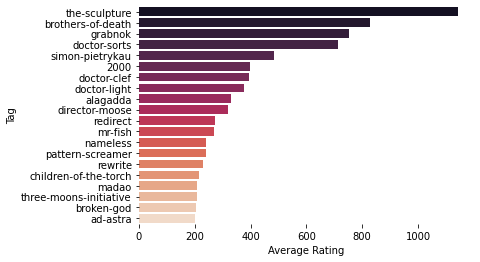

In [44]:
bar = seaborn.barplot([i[1] for i in highest_rated_tags], [i[0] for i in highest_rated_tags], orient= 'h', palette="rocket")
seaborn.despine(left=True, bottom=True)
bar.set_xlabel('Average Rating')
bar.set_ylabel('Tag')

In [45]:
# lowest rated tags - **again prob adjust
lowest_rated_tags = sorted(avg_tag_ratings.items(), reverse= True, key=operator.itemgetter(1))[-20:]
print(lowest_rated_tags)

[('formic', 147.07142857142858), ('memoria-adytum', 140.6875), ('map', 140.52941176470588), ('cube', 137.8181818181818), ('skeletal', 134.3181818181818), ('simian', 128.2962962962963), ('vermian', 128.0), ('musical', 122.44594594594595), ('memecon2021-unofficial', 118.14285714285714), ('director-diaghilev', 113.0), ('thermodynamic', 108.5), ('_meets-the-eye', 103.63636363636364), ('doctor-wettle', 102.83333333333333), ('collab-con2019', 91.6923076923077), ('canon2020', 90.0), ('hmfscp', 88.63636363636364), ('_tropical', 78.93333333333334), ('unusual-cargo', 58.8), ('doctor-rivera', 50.166666666666664), ('_llicensebox', 42.0)]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Tag')

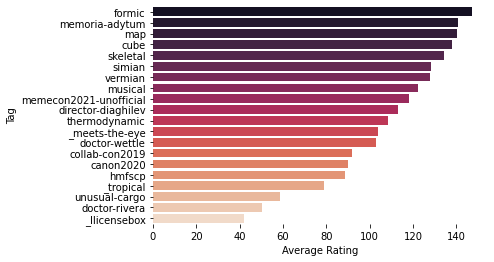

In [46]:
bar = seaborn.barplot([i[1] for i in lowest_rated_tags], [i[0] for i in lowest_rated_tags], orient= 'h', palette="rocket")
seaborn.despine(left=True, bottom=True)
bar.set_xlabel('Average Rating')
bar.set_ylabel('Tag')

In [48]:
# tag frequency vs avg rating
freq_of_tags = dict([(i, len([x for x in list(scp_df['tags']) if i in str(x).split()])) for i in unique_tags])
print(freq_of_tags)

{'redirect': 40, 'cadaver': 350, 'marshall-carter-and-dark': 123, 'predatory': 198, 'tool': 95, 'extremity': 48, 'entropic': 38, 'golden-horde': 2, 'canine': 87, 'director-bold': 6, 'inscription': 37, 'decommissioning-dept': 10, 'mtf2016': 12, '6000': 85, 'doctor-lillihammer': 10, 'rats-nest': 2, 'artifact': 354, 'subterranean': 170, 'self-repairing': 168, 'ontokinetic': 315, 'species': 260, 'director-moose': 20, 'rewrite': 196, '_dark-and-stormy': 6, 'plant': 241, '2000': 30, 'nameless': 29, 'statue': 75, 'alexylva': 14, 'extradimensional': 625, 'antarctic-exchange': 2, 'end-of-death': 17, '8-ball': 2, 'document': 337, 'extraterrestrial': 302, 'reproductive': 79, 'fungus': 51, 'draven-kondraki': 2, 'antimemetic': 158, 'herman-fuller': 31, 'dc-al-fine': 5, 'poetry': 2, 'fifthist': 58, 'donkman': 2, 'hard-to-kill-reptile': 10, 'genetic': 44, 'vehicle': 243, 'jam-con2019': 54, 'chelonian': 14, 'riven-mercer': 1, 'obearwatch': 4, 'd-7294': 2, 'chemical': 107, 'neurological': 157, 'agent-t

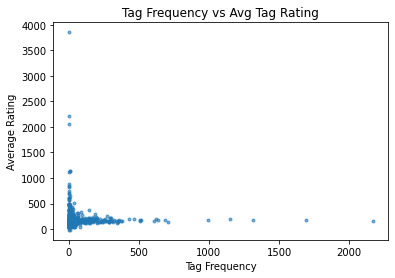

In [49]:
#plotting frequency of tag vs tag avg rating
fig1, ax1 = plt.subplots()
ax1.set_title('Tag Frequency vs Avg Tag Rating')
ax1.set_xlabel('Tag Frequency')
ax1.set_ylabel('Average Rating')
plt.scatter([v for k,v in freq_of_tags.items()], [v for k,v in avg_tag_ratings.items()], marker='.', alpha=0.6)

#### Ratings Adult Content vs Other

In [60]:
# average rating - age restricted
age_restricted = scp_df.loc[scp_df['state']=='age restricted']['rating']
avg_rating_adult = round(sum(age_restricted)/len(age_restricted))
print('Average rating for adult content: {}'.format(avg_rating_adult))

main_active = [i for i in scp_df.loc[scp_df['state']=='active']['rating'] if ~np.isnan(i)]
avg_main_rating = round(sum(main_active)/len(main_active))
print('Average rating for main articles: {}'.format(avg_main_rating))

Average rating for adult content: 265
Average rating for main articles: 171


Interestingly, the main batch of active articles have a significantly lower average rating than the 'age restricted' articles.

### Image Captions

In [ ]:
# frequency

In [ ]:
# text